In [1]:
import os, sys
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import torch
from torchvision.models import alexnet, vgg19, inception_v3, resnet50
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import timm
from thop import profile
from tool import trainer, imageDataset, model_complexity, visualizing_tool
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import normalize
import segmentation_models_pytorch as smp
torch.__version__

'1.10.1+cu113'

In [2]:
RANDOM_STATE = 100
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
TEST_SIZE = 0.15

### 讀取資料

In [3]:
# dir_path = './data/'
dir_path = './augdata/'
dir_list = ['normal', 'osteopenia', 'osteoporosis']

data_path, labels = [], []
for index, item in enumerate(dir_list):
    images = os.listdir(dir_path + item)
    for image in images:
        if image[0] != '.':
            data_path.append(dir_path + item + '/' + image)
            labels.append(index)
            
label_num = [0, 0, 0]
for i in labels:
    label_num[int(i)] += 1
print(label_num)
print(f'資料共{len(data_path)}筆')

[324, 308, 343]
資料共975筆


### 資料前處理

In [4]:
def data_preprocess(paths):
    features = []
    for path in tqdm(paths):
        # 讀取image，並轉為灰階影像
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))
        img = np.transpose(img, (2, 0, 1)).astype('float32')
        # 標準化(MaxAbs)，灰階影像最大為255
        img = img / 255
        features.append(img)
        
    return features

### OneHotEncoding

In [5]:
# 轉成np.array再轉成oneHotEncoding
def OneHotEncoding(labels):
    y = np.eye(3)[np.array(list(map(int, labels)))]
    return y

### 切分資料

In [6]:
%%time
X_train, X_valid, Y_train, Y_valid = train_test_split(data_path, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels)
print(f'訓練資料共{len(X_train)}筆')
print(f'驗證資料共{len(X_valid)}筆')

訓練資料共828筆
驗證資料共147筆
CPU times: user 3.69 ms, sys: 0 ns, total: 3.69 ms
Wall time: 3.34 ms


### 各label分布

In [7]:
label_num = [0, 0, 0]
for i in Y_train:
    label_num[int(i)] += 1
print(label_num)

[275, 262, 291]


### Data Preocess and set DataLoader

In [8]:
%%time
train_data = imageDataset(data_preprocess(X_train), OneHotEncoding(Y_train))
val_data = imageDataset(data_preprocess(X_valid), OneHotEncoding(Y_valid))

# set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set sampler
# sampler = WeightedRandomSampler([1,1,1], label_num[0]*3)
# set the DataLoader
# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler = sampler)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle = False)

  0%|          | 0/828 [00:00<?, ?it/s]

  0%|          | 0/147 [00:00<?, ?it/s]

CPU times: user 26.4 s, sys: 2.5 s, total: 28.9 s
Wall time: 28.9 s


# 各模型比較

### alexnet
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

--------------------Epoch 1--------------------
Train_accuracy: 0.362 | Train_loss: 29.496
--------------------Epoch 2--------------------
Train_accuracy: 0.449 | Train_loss: 27.681
--------------------Epoch 3--------------------
Train_accuracy: 0.559 | Train_loss: 25.322
--------------------Epoch 4--------------------
Train_accuracy: 0.649 | Train_loss: 21.055
--------------------Epoch 5--------------------
Train_accuracy: 0.723 | Train_loss: 16.034
--------------------Epoch 6--------------------
Train_accuracy: 0.771 | Train_loss: 13.848
--------------------Epoch 7--------------------
Train_accuracy: 0.820 | Train_loss: 11.199
--------------------Epoch 8--------------------
Train_accuracy: 0.857 | Train_loss: 8.384
--------------------Epoch 9--------------------
Train_accuracy: 0.890 | Train_loss: 7.275
--------------------Epoch 10--------------------
Train_accuracy: 0.902 | Train_loss: 6.457


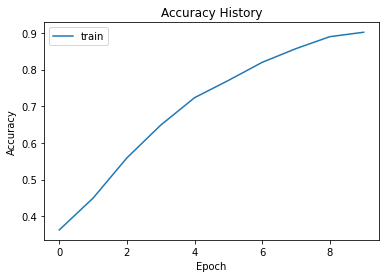

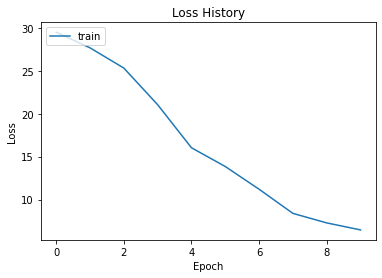

----------------------------------------------------
Accuracy on the test images: 0.673
Specificity on the test images: 0.695
Sensitivity on the test images: 0.848
AUC Score on the test images: 0.856
Inference time: 2.421 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Macs = 22.724G
Params = 57.016M


In [9]:
# pre-trained model(https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet)
alexnet_model = alexnet(pretrained=True).to(device)
# Modify the last layer(num_classes: 1000 => 3), Replace the last layer with a new fully connected layer with 3 output units(ChatGPT)
alexnet_model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
alexnet_trainer = trainer(alexnet_model, train_loader, test_loader, EPOCHS, 0.00013, False)
# train process
alexnet_trainer.train()
alexnet_trainer.predict()
# macs
macs = model_complexity(alexnet_model, BATCH_SIZE)
macs.call()

### VGG19
- https://pytorch.org/vision/0.11/models.html?highlight=vgg19#torchvision.models.vgg19

--------------------Epoch 1--------------------
Train_accuracy: 0.355 | Train_loss: 28.817
--------------------Epoch 2--------------------
Train_accuracy: 0.501 | Train_loss: 26.786
--------------------Epoch 3--------------------
Train_accuracy: 0.621 | Train_loss: 23.296
--------------------Epoch 4--------------------
Train_accuracy: 0.711 | Train_loss: 18.826
--------------------Epoch 5--------------------
Train_accuracy: 0.787 | Train_loss: 13.744
--------------------Epoch 6--------------------
Train_accuracy: 0.829 | Train_loss: 11.053
--------------------Epoch 7--------------------
Train_accuracy: 0.899 | Train_loss: 7.398
--------------------Epoch 8--------------------
Train_accuracy: 0.917 | Train_loss: 5.745
--------------------Epoch 9--------------------
Train_accuracy: 0.942 | Train_loss: 4.444
--------------------Epoch 10--------------------
Train_accuracy: 0.961 | Train_loss: 2.942


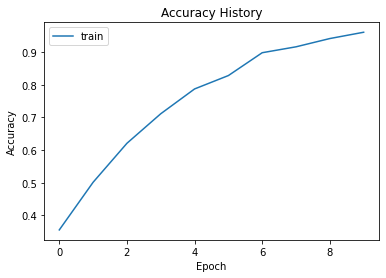

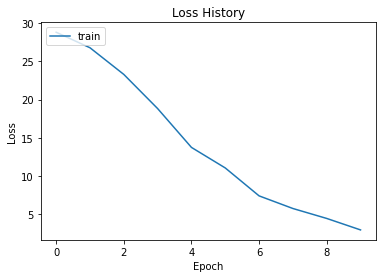

----------------------------------------------------
Accuracy on the test images: 0.810
Specificity on the test images: 0.816
Sensitivity on the test images: 0.913
AUC Score on the test images: 0.915
Inference time: 37.570 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Macs = 628.097G
Params = 139.583M


In [10]:
vgg19_model = vgg19(pretrained=True).to(device)
vgg19_model.classifier[6] = torch.nn.Linear(4096, 3).to(device)
vgg19_trainer = trainer(vgg19_model, train_loader, test_loader, EPOCHS, 1e-5, False)
vgg19_trainer.train()
vgg19_trainer.predict()

macs = model_complexity(vgg19_model, BATCH_SIZE)
macs.call()

### resnet50
- https://pytorch.org/vision/0.11/models.html?highlight=alexnet#torchvision.models.alexnet

--------------------Epoch 1--------------------
Train_accuracy: 0.534 | Train_loss: 23.703
--------------------Epoch 2--------------------
Train_accuracy: 0.865 | Train_loss: 9.441
--------------------Epoch 3--------------------
Train_accuracy: 0.911 | Train_loss: 6.406
--------------------Epoch 4--------------------
Train_accuracy: 0.948 | Train_loss: 3.514
--------------------Epoch 5--------------------
Train_accuracy: 0.957 | Train_loss: 3.477
--------------------Epoch 6--------------------
Train_accuracy: 0.969 | Train_loss: 2.219
--------------------Epoch 7--------------------
Train_accuracy: 0.967 | Train_loss: 1.997
--------------------Epoch 8--------------------
Train_accuracy: 0.966 | Train_loss: 2.379
--------------------Epoch 9--------------------
Train_accuracy: 0.957 | Train_loss: 2.734
--------------------Epoch 10--------------------
Train_accuracy: 0.966 | Train_loss: 2.357


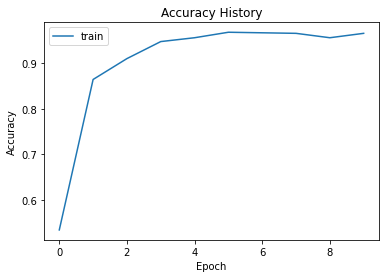

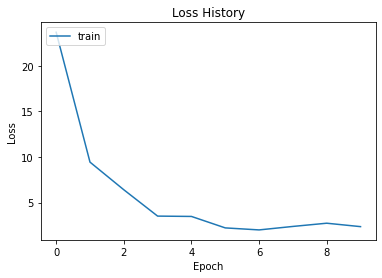

----------------------------------------------------
Accuracy on the test images: 0.803
Specificity on the test images: 0.829
Sensitivity on the test images: 0.913
AUC Score on the test images: 0.920
Inference time: 23.904 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Macs = 132.214G
Params = 23.514M


In [11]:
resnet50_model = resnet50(pretrained=True).to(device)
num_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(num_features, 3).to(device)

resnet_trainer = trainer(resnet50_model, train_loader, test_loader, EPOCHS, 0.00015, False)
resnet_trainer.train()
resnet_trainer.predict()

macs = model_complexity(resnet50_model, BATCH_SIZE)
macs.call()

### inception_v4
- https://huggingface.co/docs/timm/models/inception-v4

--------------------Epoch 1--------------------
Train_accuracy: 0.457 | Train_loss: 28.009
--------------------Epoch 2--------------------
Train_accuracy: 0.682 | Train_loss: 18.944
--------------------Epoch 3--------------------
Train_accuracy: 0.778 | Train_loss: 14.354
--------------------Epoch 4--------------------
Train_accuracy: 0.879 | Train_loss: 8.478
--------------------Epoch 5--------------------
Train_accuracy: 0.886 | Train_loss: 8.150
--------------------Epoch 6--------------------
Train_accuracy: 0.907 | Train_loss: 6.649
--------------------Epoch 7--------------------
Train_accuracy: 0.917 | Train_loss: 6.085
--------------------Epoch 8--------------------
Train_accuracy: 0.923 | Train_loss: 5.121
--------------------Epoch 9--------------------
Train_accuracy: 0.946 | Train_loss: 4.306
--------------------Epoch 10--------------------
Train_accuracy: 0.958 | Train_loss: 2.839


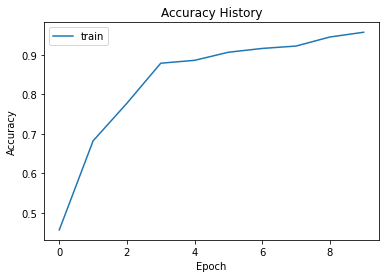

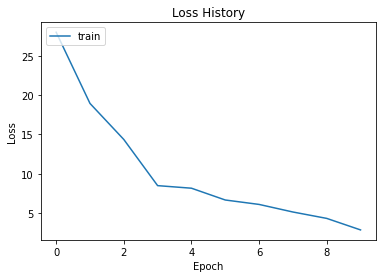

----------------------------------------------------
Accuracy on the test images: 0.871
Specificity on the test images: 0.882
Sensitivity on the test images: 0.939
AUC Score on the test images: 0.961
Inference time: 34.505 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
Macs = 196.914G
Params = 41.143M


In [12]:
inception_v4_model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(inception_v4_model, train_loader, test_loader, EPOCHS, 0.0005, False)
inception_v4_trainer.train()
inception_v4_trainer.predict()
macs = model_complexity(inception_v4_model, BATCH_SIZE)
macs.call()

--------------------Epoch 1--------------------
Train_accuracy: 0.511 | Train_loss: 25.621
--------------------Epoch 2--------------------
Train_accuracy: 0.860 | Train_loss: 12.421
--------------------Epoch 3--------------------
Train_accuracy: 0.948 | Train_loss: 4.697
--------------------Epoch 4--------------------
Train_accuracy: 0.954 | Train_loss: 3.920
--------------------Epoch 5--------------------
Train_accuracy: 0.965 | Train_loss: 3.085
--------------------Epoch 6--------------------
Train_accuracy: 0.972 | Train_loss: 2.130
--------------------Epoch 7--------------------
Train_accuracy: 0.960 | Train_loss: 3.374
--------------------Epoch 8--------------------
Train_accuracy: 0.969 | Train_loss: 2.891
--------------------Epoch 9--------------------
Train_accuracy: 0.965 | Train_loss: 2.419
--------------------Epoch 10--------------------
Train_accuracy: 0.975 | Train_loss: 2.133


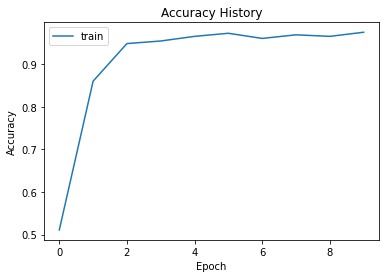

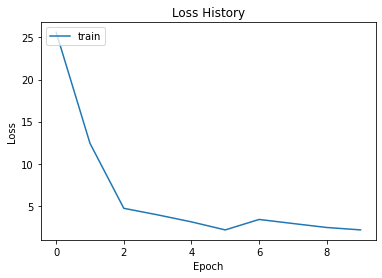

----------------------------------------------------
Accuracy on the test images: 0.823
Specificity on the test images: 0.841
Sensitivity on the test images: 0.922
AUC Score on the test images: 0.938
Inference time: 34.730 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
Macs = 196.914G
Params = 41.143M


In [13]:
inception_v4_model = timm.create_model('inception_v4', pretrained=True, num_classes=3).to(device)
inception_v4_trainer = trainer(inception_v4_model, train_loader, test_loader, EPOCHS, 0.0001, False)
inception_v4_trainer.train()
inception_v4_trainer.predict()
macs = model_complexity(inception_v4_model, BATCH_SIZE)
macs.call()

### Visual Transformer

--------------------Epoch 1--------------------
Train_accuracy: 0.356 | Train_loss: 50.010
--------------------Epoch 2--------------------
Train_accuracy: 0.343 | Train_loss: 30.568
--------------------Epoch 3--------------------
Train_accuracy: 0.376 | Train_loss: 31.593
--------------------Epoch 4--------------------
Train_accuracy: 0.415 | Train_loss: 28.352
--------------------Epoch 5--------------------
Train_accuracy: 0.461 | Train_loss: 27.026
--------------------Epoch 6--------------------
Train_accuracy: 0.508 | Train_loss: 25.313
--------------------Epoch 7--------------------
Train_accuracy: 0.610 | Train_loss: 21.519
--------------------Epoch 8--------------------
Train_accuracy: 0.784 | Train_loss: 14.000
--------------------Epoch 9--------------------
Train_accuracy: 0.878 | Train_loss: 8.735
--------------------Epoch 10--------------------
Train_accuracy: 0.915 | Train_loss: 5.961


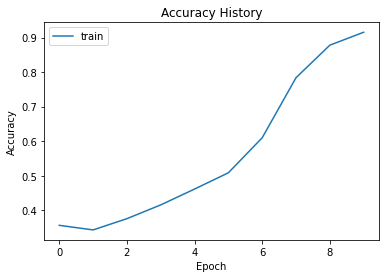

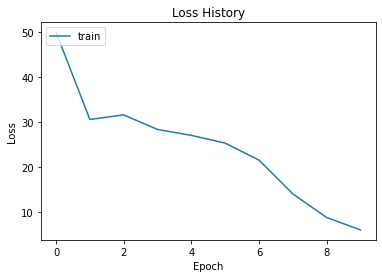

----------------------------------------------------
Accuracy on the test images: 0.741
Specificity on the test images: 0.765
Sensitivity on the test images: 0.880
AUC Score on the test images: 0.901
Inference time: 46.289 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Macs = 539.612G
Params = 85.649M


In [14]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=3).to(device)
vit_trainer = trainer(vit_model, train_loader, test_loader, EPOCHS, 0.00005, False)
vit_trainer.train()
vit_trainer.predict()
macs = model_complexity(vit_model, BATCH_SIZE)
macs.call()

### Swin-Transformer
- https://github.com/microsoft/Swin-Transformer

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


--------------------Epoch 1--------------------
Train_accuracy: 0.415 | Train_loss: 27.995
--------------------Epoch 2--------------------
Train_accuracy: 0.621 | Train_loss: 21.591
--------------------Epoch 3--------------------
Train_accuracy: 0.813 | Train_loss: 12.080
--------------------Epoch 4--------------------
Train_accuracy: 0.889 | Train_loss: 7.457
--------------------Epoch 5--------------------
Train_accuracy: 0.925 | Train_loss: 4.993
--------------------Epoch 6--------------------
Train_accuracy: 0.957 | Train_loss: 3.404
--------------------Epoch 7--------------------
Train_accuracy: 0.986 | Train_loss: 1.396
--------------------Epoch 8--------------------
Train_accuracy: 0.979 | Train_loss: 1.945
--------------------Epoch 9--------------------
Train_accuracy: 0.967 | Train_loss: 2.358
--------------------Epoch 10--------------------
Train_accuracy: 0.983 | Train_loss: 1.316


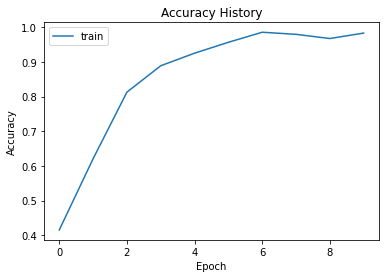

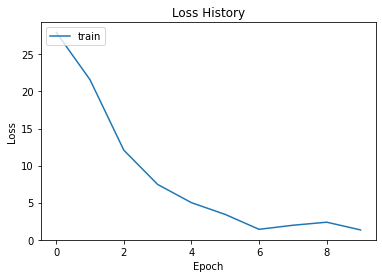

----------------------------------------------------
Accuracy on the test images: 0.823
Specificity on the test images: 0.844
Sensitivity on the test images: 0.917
AUC Score on the test images: 0.962
Inference time: 81.960 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
Macs = 485.402G
Params = 86.683M


In [15]:
swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=3).to(device)
swin_trainer = trainer(swin_model, train_loader, test_loader, EPOCHS, 0.00005, False)
swin_trainer.train()
swin_trainer.predict()
macs = model_complexity(swin_model, BATCH_SIZE)
macs.call()

### UNet
- https://github.com/qubvel/segmentation_models.pytorch
- https://ithelp.ithome.com.tw/articles/10240314

--------------------Epoch 1--------------------
Train_accuracy: 0.364 | Train_loss: 28.979
--------------------Epoch 2--------------------
Train_accuracy: 0.408 | Train_loss: 28.199
--------------------Epoch 3--------------------
Train_accuracy: 0.486 | Train_loss: 26.862
--------------------Epoch 4--------------------
Train_accuracy: 0.458 | Train_loss: 27.274
--------------------Epoch 5--------------------
Train_accuracy: 0.482 | Train_loss: 26.667
--------------------Epoch 6--------------------
Train_accuracy: 0.466 | Train_loss: 26.369
--------------------Epoch 7--------------------
Train_accuracy: 0.516 | Train_loss: 25.891
--------------------Epoch 8--------------------
Train_accuracy: 0.533 | Train_loss: 25.285
--------------------Epoch 9--------------------
Train_accuracy: 0.568 | Train_loss: 23.913
--------------------Epoch 10--------------------
Train_accuracy: 0.610 | Train_loss: 22.801


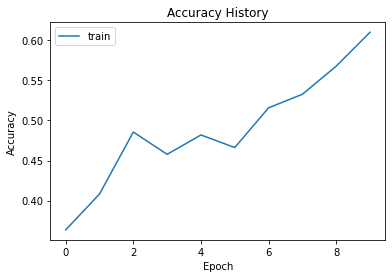

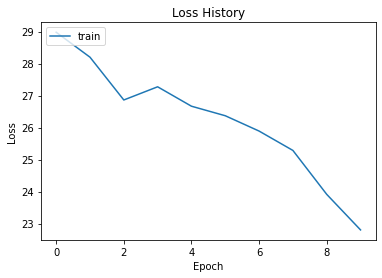

----------------------------------------------------
Accuracy on the test images: 0.571
Specificity on the test images: 0.580
Sensitivity on the test images: 0.786
AUC Score on the test images: 0.750
Inference time: 24.197 milliseconds
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Macs = 192.782G
Params = 24.437M


In [16]:
unet_model = smp.Unet(
                 encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                 encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
                 in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                 classes=3                       # model output channels (number of classes in your dataset)
             ).to(device)

# unet_trainer = trainer(unet_model, train_loader, test_loader, 50, 1e-3, True)
unet_trainer = trainer(unet_model, train_loader, test_loader, 10, 1e-3, True)
unet_trainer.train()
unet_trainer.predict()
macs = model_complexity(unet_model, BATCH_SIZE)
macs.call()

### Visualizing and Understanding Convolutional Networks
- https://github.com/huggingface/pytorch-image-models/discussions/1232

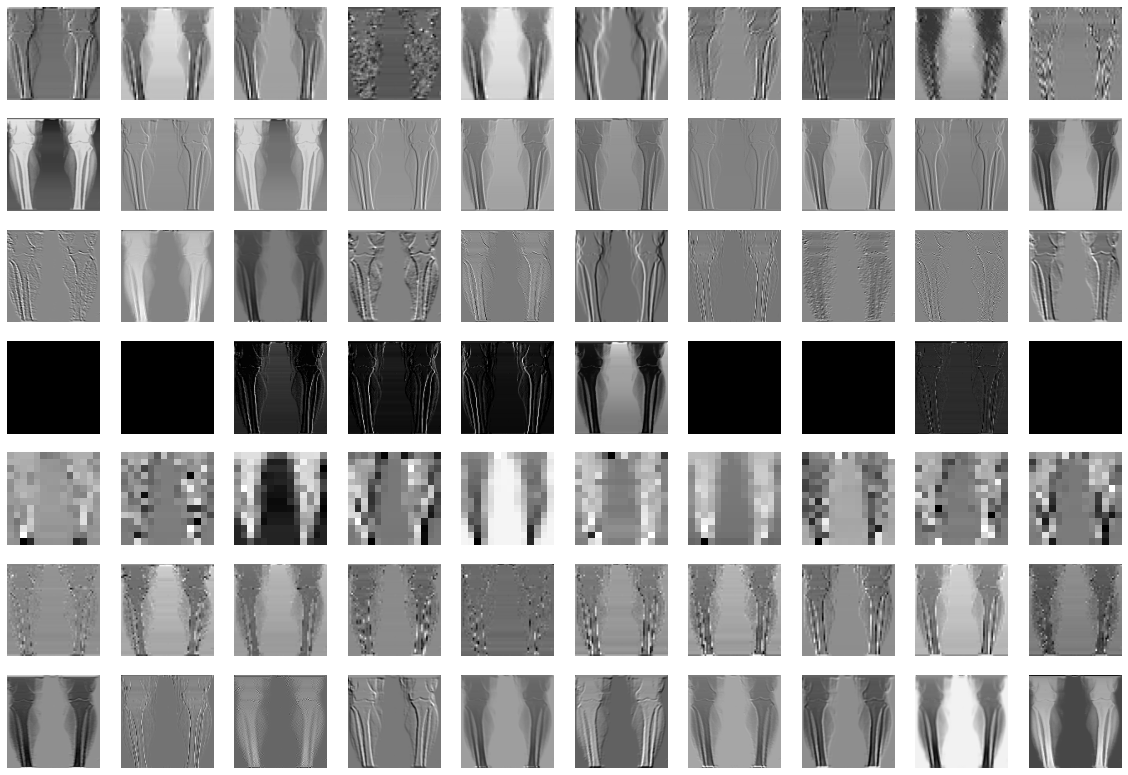

In [17]:
# 7個模型的比較
models = [alexnet_trainer.model, vgg19_trainer.model, resnet_trainer.model, inception_v4_trainer.model,vit_trainer.model, swin_trainer.model, unet_trainer.model]
# visual_tool = visualizing_tool(train_loader, [alexnet_model, vgg19_model, resnet50_model, inception_v4_model, vit_model, swin_model, unet_model])
visual_tool = visualizing_tool(train_loader, models)
visual_tool.call()

VGG19 前5層架構的特徵視覺化圖


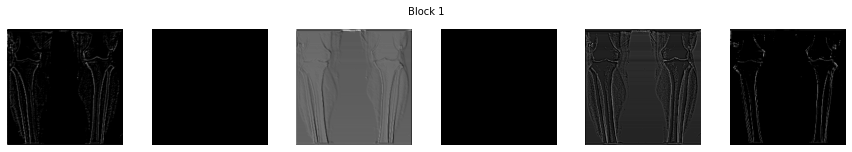

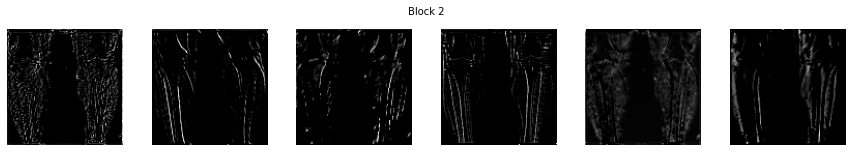

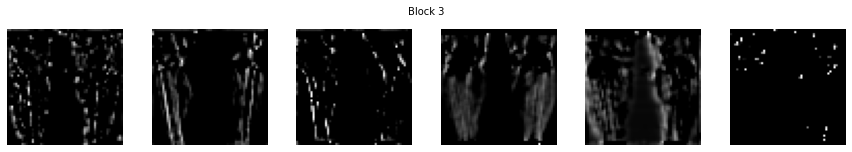

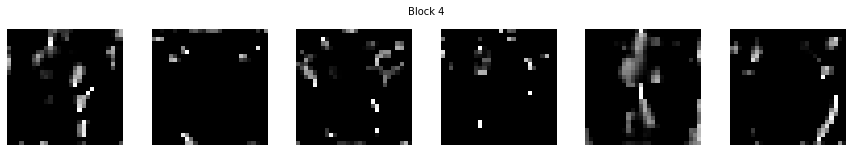

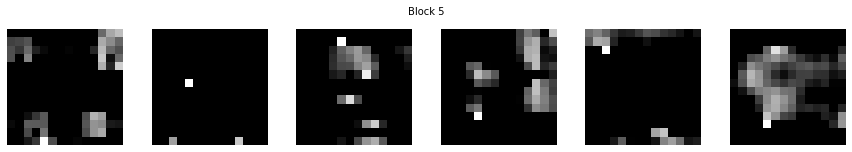

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Vision Transformer 12層架構的特徵視覺化圖


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


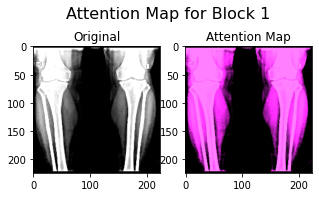

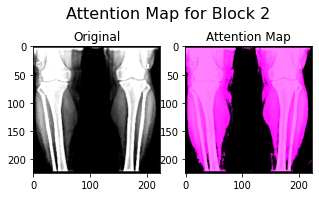

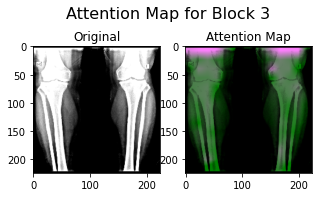

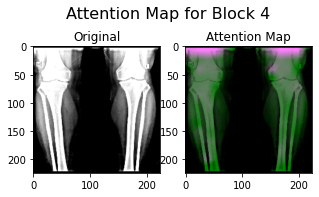

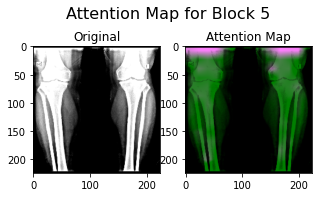

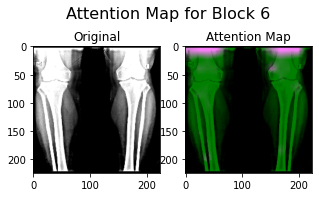

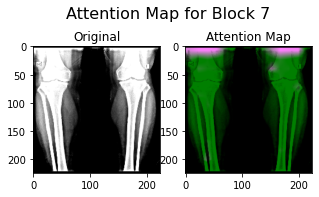

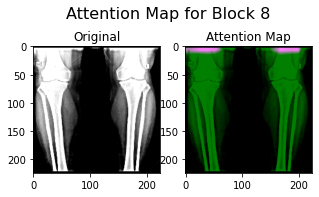

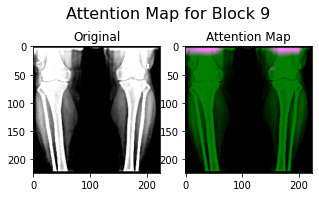

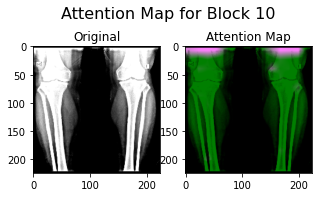

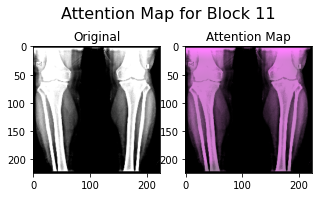

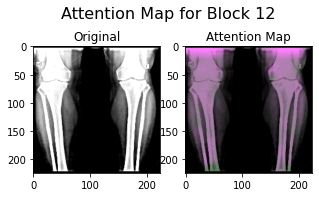

In [18]:
# VGG19及ViT的進階特徵視覺化圖
visual_tool.feature_process()